# Set up

## Import

In [1]:
#import
import numpy as np
import pandas as pd

#system packages
import os
import glob

#spatial packages
from rastertodataframe import raster_to_dataframe
from osgeo.gdalconst import *
from osgeo import gdal
from scipy.ndimage import gaussian_filter, median_filter

#visualization
import matplotlib.pyplot as plt
from matplotlib import cm

#processing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import cluster

#modeling
from sklearn import svm, datasets
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

#evaluation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, balanced_accuracy_score

#misc
from math import floor
from itertools import product
from copy import deepcopy

## Download data

In [2]:
#custom functions

#function to create histogram of scenes class frequency
def nrcan_hist(img):
    import numpy as np
    import pandas as pd
    from collections import Counter

    im_array = np.array(img)

    #last line is bad values 
    im_array = im_array[:-1]

    #value count
    freq = Counter(im_array.flatten())

    plt.bar(freq.keys(), freq.values())
    plt.xlim([-1, 20])
    
#function to turn tiff to df
def tiff_to_df_colab(path):

    #Create folder path and list variables
    folder_path = path
    file_list = glob.glob(folder_path + "/*.tiff")

    #initiate empty dataframe
    main_dataframe = pd.DataFrame()

    for i in file_list:
        data = raster_to_dataframe(i)
  
        #extract name of band from file path
        band_info = str(i).split('/')[-1]
        band_name = band_info[-14:-11]
        #rename with band name
        data = data.rename(columns = {'Band_1': band_name})
        #merge into main dataframe
        main_dataframe = pd.concat([main_dataframe, data], axis = 1)

    return main_dataframe


def filter_raws(path_to_dir,  sigma = 1, nrcan_name = 'NRCAN_transformed.tif', index = [-14, -11], filter_type = 'gaussian'):
    raw_files = list(os.listdir(path_to_dir))

    filter_df = pd.DataFrame()
    for i in raw_files[:]:
        raw_img = gdal.Open(os.path.join(path_to_dir, i))
        rows = raw_img.RasterYSize
        cols = raw_img.RasterXSize
        
        raw_array = np.array(raw_img.ReadAsArray())
        
        if filter_type == 'gaussian':
            raw_filter = gaussian_filter(raw_array, sigma = sigma)
        elif filter_type == 'median':
            raw_filter = median_filter(raw_array, size = 10)
        
        raw_filter = raw_filter.flatten()
        filter_df[i[index[0]:index[1]]] = raw_filter
    
    nrcan = gdal.Open(os.path.join(path_to_dir, '..', nrcan_name))
    nrcan_array = np.array(nrcan.ReadAsArray())
    
    filter_df['y'] = nrcan_array.flatten()
    return filter_df

In [3]:
#custom function using gdal to convert raster to dataframe
def gdal_to_dataframe(dir_path, nrcan_name = 'NRCAN_transformed.tif', index = [-14, -11]):
    raw_names = list(os.listdir(dir_path))
    
    raw_df = pd.DataFrame()
    
    for i in raw_names:
        raw_img = gdal.Open(os.path.join(dir_path, i))
        
        raw_array = np.array(raw_img.ReadAsArray()).flatten()
        raw_df[i[index[0]:index[1]]] = raw_array
    
    nrcan = gdal.Open(os.path.join(dir_path, '..', nrcan_name))
    nrcan_array = np.array(nrcan.ReadAsArray())
    
    raw_df['y'] = nrcan_array.flatten()
    
    return raw_df

tor_raws = gdal_to_dataframe('../data_tests/scene_5/raws')
tor_raws.head()

,B01,B02,B03,B04,B05,B06,B07,B08,B09,B11,B12,B8A,y
0,0.0934,0.1228,0.1588,0.2052,0.2344,0.2549,0.2729,0.2928,0.2947,0.3868,0.3853,0.2917,15
1,0.0890,0.1163,0.1507,0.1944,0.2210,0.2390,0.2560,0.2761,0.2777,0.3842,0.3827,0.2757,15
2,0.0893,0.1157,0.1511,0.1944,0.2199,0.2363,0.2552,0.2752,0.2764,0.3886,0.3842,0.2765,15
3,0.1104,0.1609,0.1919,0.2144,0.2526,0.2926,0.3128,0.3342,0.3254,0.3672,0.3320,0.3325,15
4,0.0723,0.0913,0.1220,0.1250,0.1730,0.2769,0.3134,0.3368,0.3366,0.3020,0.2353,0.3376,15


In [4]:
#load gaussian filtered raws
sim_raws = gdal_to_dataframe('../data_tests/simcoe_york/raws', nrcan_name = 'Simcoe_York_2019.tif')
lab_raws = gdal_to_dataframe('../data_tests/labrador/raws')
james_raws = gdal_to_dataframe('../data_tests/james_bay/raws', nrcan_name = 'James_Bay_Med.tif')
tor_raws = gdal_to_dataframe('../data_tests/scene_5/raws')
sjames_raws = gdal_to_dataframe('../data_tests/james_south/raws')
cal_raws = gdal_to_dataframe('../data_tests/calgary/raws')
trois_raws = gdal_to_dataframe('../data_tests/trois/raws')

In [5]:
stop

NameError: name 'stop' is not defined

# EDA & Feature Selection

In [ ]:
#plot band
map_band = np.asarray(tor_raws['B01'].values).reshape(499, 1250)
cmap = cm.get_cmap('jet', 15)    # 11 discrete colors
prediction_map = plt.imshow(map_band, cmap=cmap)

### K-means clustering

In [ ]:
def cluster_bands(dataframe, n_clusters = 4):
    
    #if y is in frame drop it
    try:
        cl_df = dataframe.drop('y', axis = 1)
    except:
        cl_df = dataframe
    cl = cluster.KMeans(n_clusters = n_clusters)
    param = cl.fit(cl_df)
    img_cl = cl.labels_
    
    dataframe['clusters'] = img_cl
    
    return param, dataframe

In [ ]:
#visualize effect with test raws
test_raws = pd.concat([sim_raws, tor_raws])
test_raws = test_raws.drop('y', axis = 1)

cl = cluster.KMeans(n_clusters=4) # create an object of the classifier
param = cl.fit(test_raws) # train it
img_cl = cl.labels_ 

#split and reshape into two images
img_tor = img_cl[2500 * 2134:].reshape(499, 1250)
img_sim = img_cl[:2500 * 2134].reshape(2134, 2500)

In [ ]:
#visualize
plt.figure(figsize=[20,20])
plt.imshow(img_tor, cmap=cmap)
plt.axis('off')

### Gaussian filtering

In [6]:
#load gaussian filtered raws
sim_gauss = filter_raws('../data_tests/simcoe_york/raws', nrcan_name = 'Simcoe_York_2019.tif')
lab_gauss = filter_raws('../data_tests/labrador/raws')
james_gauss = filter_raws('../data_tests/james_bay/raws', nrcan_name = 'James_Bay_Med.tif')
tor_gauss = filter_raws('../data_tests/scene_5/raws')
sjames_gauss = filter_raws('../data_tests/james_south/raws')
cal_gauss = filter_raws('../data_tests/calgary/raws')
trois_gauss = filter_raws('../data_tests/trois/raws')

In [7]:
#put together raw and gauss df of each scene
#create list of input images
train_raw = [tor_raws, james_raws, sim_raws, lab_raws, sjames_raws, cal_raws, trois_raws]
train_gauss = [tor_gauss, james_gauss, sim_gauss, lab_gauss, sjames_gauss, cal_gauss, trois_gauss]

#set empty main
main_dataframe = pd.DataFrame()

for i in range(len(train_raw)):
    #drop y from gauss
    temp_gauss = train_gauss[i].drop('y', axis = 1)
    #rename gauss columns
    gauss_names = [f'{name}g' for name in temp_gauss.columns]
    temp_gauss.columns = gauss_names
    #print(temp_gauss.head(), train_raw[i].head())
    
    #reset indices
    train_raw[i].reset_index(inplace=True, drop=True)
    temp_gauss.reset_index(inplace=True, drop=True)       
    new_df = pd.concat([train_raw[i], temp_gauss], axis = 1)
    #add to main
    main_dataframe = pd.concat([main_dataframe, new_df])

print(new_df.shape, lab_raws.shape)
main_dataframe.head()

(820000, 25) (2082500, 13)


,B01,B02,B03,B04,B05,B06,B07,B08,B09,B11,...,B03g,B04g,B05g,B06g,B07g,B08g,B09g,B11g,B12g,B8Ag
0,0.0934,0.1228,0.1588,0.2052,0.2344,0.2549,0.2729,0.2928,0.2947,0.3868,...,0.155785,0.200306,0.229630,0.251208,0.269401,0.289535,0.291208,0.387628,0.383691,0.289344
1,0.0890,0.1163,0.1507,0.1944,0.2210,0.2390,0.2560,0.2761,0.2777,0.3842,...,0.153614,0.195907,0.224911,0.247467,0.266147,0.286678,0.288122,0.385571,0.378070,0.286911
2,0.0893,0.1157,0.1511,0.1944,0.2199,0.2363,0.2552,0.2752,0.2764,0.3886,...,0.153601,0.188395,0.220382,0.252966,0.274189,0.295973,0.296501,0.377357,0.357570,0.297006
3,0.1104,0.1609,0.1919,0.2144,0.2526,0.2926,0.3128,0.3342,0.3254,0.3672,...,0.149874,0.170725,0.209797,0.268326,0.295357,0.318436,0.318674,0.353493,0.312006,0.320134
4,0.0723,0.0913,0.1220,0.1250,0.1730,0.2769,0.3134,0.3368,0.3366,0.3020,...,0.142780,0.153104,0.196689,0.279738,0.311963,0.334178,0.336360,0.324612,0.265836,0.335382


In [ ]:
main_dataframe.shape

In [ ]:
#comparing example band distribution within each class across two extents
plt.scatter(lab_raws['B01'], lab_raws.y)
plt.scatter(sim_raws['B01'], sim_raws.y)

### Outlier fixing

In [ ]:
def outlier_fix(dataframe):
    
    new_frame = pd.DataFrame()
    
    for column in dataframe.columns:
        
        #make sure we don't transform y column
        if column != 'y':
            temp_band = deepcopy(dataframe.loc[:,column].values)
            outlier = np.quantile(temp_band, q = 0.75) * 2
      
            temp_band[temp_band > outlier] = np.mean(temp_band)
            new_frame[column] = temp_band
        
    try:
        new_frame['y'] = dataframe['y']
        return new_frame
    except:
        return new_frame
        
                   
james_raws['B01f'] = outlier_fix(james_raws)['B01'] 
lab_raws['B01f'] = outlier_fix(lab_raws)['B01']
sim_raws['B01f'] = outlier_fix(sim_raws)['B01']
tor_raws['B01f'] = outlier_fix(tor_raws)['B01']
sjames_raws['B01f'] = outlier_fix(sjames_raws)['B01']
cal_raws['B01f'] = outlier_fix(cal_raws)['B01']

### Combine extents

In [ ]:
#vertical concat
main_dataframe = pd.concat([tor_raws, sim_raws, lab_raws, james_raws, sjames_raws, cal_raws, trois_raws])
main_dataframe = main_dataframe.reset_index().drop('index', axis = 1)
#main_dataframe = replace_values(main_dataframe)                
#main_dataframe = pd.concat([tor_gauss, james_gauss, sim_gauss, lab_gauss])

In [8]:
cl = cluster.KMeans(n_clusters = 4)
dataframe_copy = main_dataframe.drop('y', axis = 1)
param = cl.fit(dataframe_copy.astype('double'))
img_cl = cl.labels_
    
main_dataframe['clusters'] = img_cl
    

In [ ]:
#Visulization of band distribution for each class in the main dataframe

#number of axes = number of possible combos
fig, axes = plt.subplots(4, 3, figsize = (15, 40))

for i, ax in enumerate(axes.flat):
    
    #index of columns
    X_scatter = main_dataframe[main_dataframe.columns[:-1][i]]
    Y_scatter = main_dataframe['y']
    
    # scatter current combination
    ax.scatter(X_scatter, Y_scatter)
    ax.set_title(main_dataframe.columns[i])

# Processing Data

In [ ]:
#Getting an equal sample from each image for each class -- UNDER CONSTRUCTION--
#add line in except that goes back to previous frame and samples image_threshold - count

#create list of input images
train_images = [tor_gauss, james_gauss, sim_gauss, lab_gauss]

#empty subset frame
data = pd.DataFrame()

#for each image in input images
for i in range(len(train_images)):
    
    image = train_images[i]
    
    #drop 0
    image = image.loc[image.y != 0]
    
    #get class totals
    image_classes = image.value_counts('y').sort_index() 
    
    #define class threshold and threshold for class in each image
    class_threshold = 80000
    image_threshold = int(class_threshold / (len(train_images))) * 3
    
    #init empty frame to store data for each image
    subset = pd.DataFrame()
    
    #for each class
    for label in image_classes.index:
        #try to sample the image class threshold
        try:
            label_subset = image.loc[image.y == label[0]].sample(n= image_threshold, random_state=24)
        #if not possible (threshold > existing class count) then sample class count
        except:
            temp = image.loc[image.y == label[0]]
            label_subset = temp.sample(n = len(temp), random_state=24)
           
        #concat class subset into data 
        subset = pd.concat([subset, label_subset])
        
    #concat data into subset frame
    data = pd.concat([data, subset])
    
data.value_counts('y').sort_index() 

### Calculated Layers

In [ ]:
 #normalized NIR/Blue normalized veg index
    df['NIRB'] = (df.B08 - df.B02)/(df.B08 + df.B02)
    #green normalized difference veg index
    df['NIRB'] = (df.B08 - df.B03)/(df.B08 + df.B03)
    #Atmospheric Resistant Green
    df['ARG'] = (df.B03 - df.B04)/(df.B03 + df.B04)
    # yellow veg index
    df['yellow'] = (0.723 * df.B03) - (0.597 * df.B04) + (0.206 * df.B06) - (0.278 * df.B09)
    #Mid-infrared veg index
    df['ARG'] = df.B09/df.B11
    #GDVI
    df['GDVI'] = df.B08 - df.B03

In [ ]:
def add_layers(df):
    """
    This function takes in a dataframe and calculates the NDVI, Moisture Index, NDWI and NDSI
    Outputs = dataframe with added layer columns 
    """
    #Create NDVI column (B08-B04)/(B08+B04)
    df['NDVI'] = (df.B08 - df.B04)/(df.B08 + df.B04)
    #Create Moisture index (B8A-B11)/(B8A+B11)
    df['Moisture'] = (df.B8A - df.B11)/(df.B8A + df.B11)
    #Create NDWI (B3-B8)/(B3+B8)
    df['NDWI'] = (df.B03 - df.B08)/(df.B03 + df.B08)
    #create NDSI (B3-B11)/(B3+B11)
    df['NDSI'] = (df.B03 - df.B11)/(df.B03 + df.B11)

   
    return df
    
def replace_values(df):
    """
    This function replaces the infinity values with Nan then replaces that with new infinity values
    """
    #Replace infinity values with Nan
    df.replace([np.inf, -np.inf], np.NAN, inplace=True)

    #Fill in null values
    df.fillna(999, inplace=True)

    return df

In [ ]:
test_plus = add_layers(trois_raws)
test_plus = replace_values(test_plus)

#preview calculated layers
map_band = np.asarray(test_plus['GDVI'].values).reshape(656, 1250)
cmap = cm.get_cmap('jet', 15)    # 11 discrete colors
prediction_map = plt.imshow(map_band, cmap=cmap)

In [ ]:
main_dataframe = add_layers(main_dataframe)
main_dataframe = replace_values(main_dataframe)

#only keep filtered bands
#main_dataframe = main_dataframe.iloc[:, 12:]

### Subsampling

In [ ]:
main_dataframe.columns

In [16]:
#check dataframe shape and print class value counts
print(main_dataframe.shape)
main_classes = main_dataframe.value_counts('y').sort_index() 
print(main_classes)

(12855000, 26)
y 
0      181478
1     1470701
2      309088
5     1012590
6      731706
8      725321
10     244266
11     165824
12     668594
13     631752
14     380344
15    3454935
16     648518
17     746862
18    1433528
19      49493
dtype: int64


In [17]:
#final clean
#drop 0
main_dataframe = main_dataframe.loc[main_dataframe.y != 0]

#select classes above threshold
threshold = 80000
top_classes = main_classes[main_classes > threshold].reset_index().y

#save dataframe subset of those classes
main_subset = main_dataframe.loc[main_dataframe['y'].isin(top_classes.values)]

#take smallest value rounded down to nearest 1000
smallest_class = int(floor(min(main_subset.value_counts('y').sort_index().values)/ 1000)) * 1000
#subsampling - comment out for full set
smallest_class = threshold

#take subset of each class equal to smallest class value
data = main_subset.groupby("y").sample(n=smallest_class, random_state=24)

#add on snow - uncomment if threshold > class total
snow_subset = main_dataframe.loc[main_dataframe.y == 19]
data = pd.concat([data, snow_subset])

print(data.shape)
data.value_counts('y').sort_index()

(1169493, 26)


y 
1     80000
2     80000
5     80000
6     80000
8     80000
10    80000
11    80000
12    80000
13    80000
14    80000
15    80000
16    80000
17    80000
18    80000
19    49493
dtype: int64

In [ ]:
#remove outliers --UNDER CONSTRUCTION--
main_dataframe = clean_raws(data)
main_dataframe.shape

## Train test split

In [18]:
y = data.y
X = data.drop('y', axis = 1)

#Dimensionality reduction - replace X with X_pca and run to try
pca = PCA(n_components = 1)
pca.fit(X)
print(pca.explained_variance_ratio_)
X_pca = pca.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, train_size=0.8, random_state = 0)

[0.67636099]


In [ ]:
#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
#scaler = StandardScaler()
#X_test = scaler.fit_transform(X_test)

# Modelling

Random Forest, SVC, XGBoost [stretch] CNN

Iteration details:
- toronto, simcoe, sask, labrador = standard bands, no parameters, 5K each value, no scaling, in turn toronto, simcoe, sask, labrador extents only
- Base run = standard bands, no parameters, 5K each value, no scaling, sim and lab
- scaled = standard bands, no params, 5K each value, StandardScaler() -> improved SVC, sask and tor
- large set = standard bands, no parameters, 18K each value, no scaling, sim and lab
- gaussian = standard bands transformed via gaussian filter, 18K each value, no scaling, sim and lab
- demo = random forest applied to demo data, unless otherwise stated used 300 trees, max depth 25 and max features 2 -> for version 11 and later it is max depth 15; Detailed map (15 color values) starts with version 10
    - version_1 = 31.41% trained on sim & lab 18K each
    - version_2 =  31.55% trained on gaussian (sigma 5) sim & lab, 18K each
    - version_3 = 33.22% trained on gaussian (sigma 1) sim & lab, 18K each
    - version_4 = 37.49% trained on gaussian (sigma 1) sim, lab, tor and james, 40K each random
    - version_5 = 34.21% trained on sim, lab, tor, james all bands, 40K each random [?? missing something can't recreate map]
    - version_6 = 33.97% (b: 34.84%) trained on raw and gaussian (sig 1) sim, lab, tor, james all bands, 40k each random
    - version_7 = 33.37% (b:33.95%) raw and median (size 10) sim, lab, tor, james all bands, 40k each random
    - version_8 = 42.11% (b:37.22%) raw with calculated layers sim, lab, tor, james all bands, 40k each
    - version_9 = 36.50 (b: 35.80%) raw with calculated layres and gauss (sig 1) sim, lab, tor, james all bands 40k each
    - version_10 = 51.23 (b: 41.03%) raw with calculated layers and column B01f with B01 where outliers < q3x2 = median sim, lab, tor, james, sjames all bands, 60k each no snow ; 15 max depth
    - version 11 = 46.11 (b: 39.43) raw with calculated layers and column B01f with B01 where outliers < q3x2 = median sim, lab, tor, james, sjames, calgary all bands, 60k each no snow
    - version 12 = 48.10 (b: 39.83) raw with calculated layers and cluster (n = 4) column; sim, lab, tor, james, sjames, cal, trois 100K classes with 49K snow class
    - special mention gauss sig 5 with calculated layers from raw

To do:
- ensure all raws are aligned to a common 60 m res grid (downsampling all but b1 and b9)
- scaling sim & lab for svc -> if goes well svc parametrization
- basic NN?

In [19]:
#set up save path for images
confusion_path = 'confusion_matrices/'
group_folder = 'base_run/'

## Random Forest

0.6293314635804342


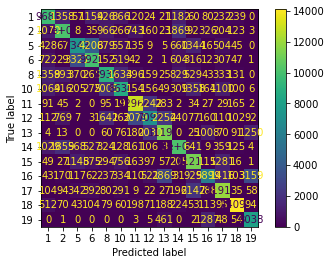

In [20]:
forest = RandomForestClassifier(random_state = 0, n_estimators = 300, max_depth = 15, max_features = 2).fit(X_train, y_train)
#get accuracy
forest_pred = forest.predict(X_test)
print(accuracy_score(y_test, forest_pred))

#plot confusion matrix
cm_forest = confusion_matrix(y_test, forest_pred)
cm_forest_fig = ConfusionMatrixDisplay(confusion_matrix = cm_forest, display_labels = forest.classes_)
cm_forest_fig.plot()

In [ ]:
#make sure there's no overfit
forest_train_pred = forest.predict(X_train)
print(accuracy_score(y_train, forest_train_pred))

In [ ]:
#check feature importance
forest.feature_importances_

In [ ]:
#save
cm_forest_fig.figure_.savefig(os.path.join(confusion_path, group_folder, 'forest.png'))
print(classification_report(y_test, forest_pred))

### Toronto extent test

In [ ]:
#get gaussian version of toronto
gauss_test = gaussian_raws('../data_tests/scene_5/raws')
gauss_test.head()

gauss_test['y'] = gauss_test['y'].replace({0:18})

In [ ]:
#split X and y values from gaussian or default raw bands
#y_tor = tor_raws.y
#X_tor = tor_raws.drop('y', axis = 1)

y_tor = gauss_test.y
X_tor = gauss_test.drop('y', axis = 1)

#add calculated layers
X_tor = add_layers(X_tor)
X_tor = replace_values(X_tor)


#optional PCA, to use replace X_tor in predict with X_tor_pca
pca = PCA(n_components = 6)
X_tor_pca = pca.fit_transform(X_tor)

#predict
tor_pred = forest.predict(X_tor)
print(balanced_accuracy_score(y_tor, tor_pred))

#display
cm_forest = confusion_matrix(y_tor, tor_pred)
cm_forest_fig = ConfusionMatrixDisplay(confusion_matrix = cm_forest, display_labels = forest.classes_)
fig, ax = plt.subplots(figsize=(10,10))
cm_forest_fig.plot(ax = ax)

In [ ]:
#display prediction map
map_pred = np.asarray(tor_pred).reshape(tor_nrcan.height, tor_nrcan.width)
cmap = cm.get_cmap('jet', 7)    # 11 discrete colors
prediction_map = plt.imshow(map_pred, cmap=cmap)

#save
#prediction_map.figure.savefig(os.path.join(confusion_path, 'gaussian', 'map_tor.png'))

### Demo test

In [ ]:
#convert into matrices to perform gaussian then convert back into 1d array and append to dataframe
X_demo_gauss = pd.DataFrame()
for band in X_demo.columns:
    band = X_demo.columns[1]
    reconstruct = np.asarray(X_demo[band]).reshape(2500, 2100).T
    recon_gauss = gaussian_filter(reconstruct, sigma = 1)
    X_demo_gauss[band] = recon_gauss.flatten()
    
#compare demo input and gauss output
fig = plt.figure(figsize = (20,20))
ax1 = fig.add_subplot(121)  # left side
ax2 = fig.add_subplot(122)  # right side

ax1.imshow(reconstruct)
ax2.imshow(recon_gauss)

In [9]:
#import demo test data
demo_raw = pd.read_csv('../data_tests/demo_site.csv')
demo_raw.land_cover = demo_raw.land_cover.astype('int')
demo_raw.head()

#test 2 - demo
y_demo = demo_raw.land_cover
X_demo = demo_raw.drop('land_cover', axis = 1)
print(X_demo.shape)

(5250000, 12)


In [10]:
#reset demo raw for matching filtering
demo_raw = gdal_to_dataframe('../data_tests/demo/raws', nrcan_name = 'land_cover.tif', index = [0, 3])
#filter raws from path
gauss_demo = filter_raws('../data_tests/demo/raws', nrcan_name = 'land_cover.tif', index = [0, 3])

#concat gauss and raw
gauss_demo_reset = gauss_demo.drop('y', axis = 1)
#rename gauss columns
gauss_names = [f'{name}g' for name in gauss_demo_reset.columns]
gauss_demo_reset.columns = gauss_names
#reset indices
demo_raw.reset_index(inplace=True, drop=True)
gauss_demo_reset.reset_index(inplace=True, drop=True)    
merged_df = pd.concat([demo_raw, gauss_demo_reset], axis = 1)

#select X values from gaussian dataframe
X_demo = merged_df.drop('y', axis = 1)
X_demo.head()

#reshape to use y_demo with gaussian X
y_demo = y_demo.values.reshape(2500, 2100).T
y_demo = y_demo.flatten()

In [11]:
main_dataframe.columns

Index(['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B11',
       'B12', 'B8A', 'y', 'B01g', 'B02g', 'B03g', 'B04g', 'B05g', 'B06g',
       'B07g', 'B08g', 'B09g', 'B11g', 'B12g', 'B8Ag', 'clusters'],
      dtype='object')

In [22]:
X_demo.columns

Index(['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B11',
       'B12', 'B8A', 'B01g', 'B02g', 'B03g', 'B04g', 'B05g', 'B06g', 'B07g',
       'B08g', 'B09g', 'B11g', 'B12g', 'B8Ag', 'clusters'],
      dtype='object')

In [ ]:
X_demo['B01f'] = outlier_fix(X_demo)['B01']

In [ ]:
X_demo = add_layers(X_demo)
X_demo = replace_values(X_demo)

#remove raw values
#X_demo = X_demo.iloc[:, 12:]

In [13]:
demo_cluster = param.predict(X_demo.astype('double'))
demo_cluster

array([1, 1, 1, ..., 1, 1, 1])

In [21]:
X_demo['clusters'] = demo_cluster

In [26]:
X_demo.columns

Index(['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B11',
       'B12', 'B8A', 'B01g', 'B02g', 'B03g', 'B04g', 'B05g', 'B06g', 'B07g',
       'B08g', 'B09g', 'B11g', 'B12g', 'B8Ag', 'clusters'],
      dtype='object')

In [23]:
#generate predictions
demo_pred = forest.predict(X_demo)

C:\Users\fynn\Documents\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


0.3810229316250391
0.44853161904761907


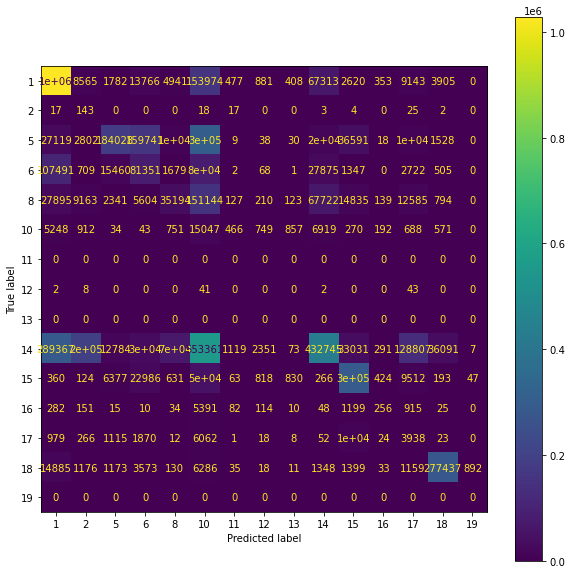

In [24]:
#accuracy
print(balanced_accuracy_score(y_demo, demo_pred))
print(accuracy_score(y_demo, demo_pred))

#confusion matrix
cm_forest = confusion_matrix(y_demo, demo_pred)
cm_forest_fig = ConfusionMatrixDisplay(confusion_matrix = cm_forest, display_labels = forest.classes_)
fig, ax = plt.subplots(figsize=(10,10))
cm_forest_fig.plot(ax = ax)

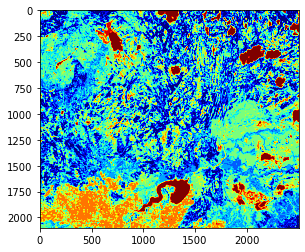

In [25]:
#plot demo prediction map
map_pred = np.asarray(demo_pred).reshape(2100, 2500)
cmap = cm.get_cmap('jet', 15)    # 11 discrete colors
prediction_map = plt.imshow(map_pred, cmap=cmap)

In [ ]:
X_plus = add_layers(X_demo)
X_plus = replace_values(tor_plus)


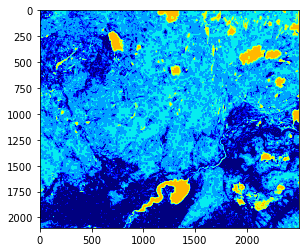

In [27]:
#plot demo prediction map
map_pred = np.asarray(X_demo['clusters']).reshape(2100, 2500)
cmap = cm.get_cmap('jet', 15)    # set discrete

prediction_map = plt.imshow(map_pred, cmap=cmap)
#prediction_map.figure.savefig(os.path.join(confusion_path, 'demo', 'true_detail.png'))

In [ ]:
#save confusion matrix
cm_forest_fig.figure_.savefig(os.path.join(confusion_path, 'demo', 'version_12.png'))

#save prediction map
prediction_map.figure.savefig(os.path.join(confusion_path, 'demo', 'map_12.png'))

## SVC

In [ ]:
#Different SVC kernels - sig performed less then 1 percent on subsample so its removed
#linear = svm.SVC(kernel='linear', C=1, decision_function_shape='ovo').fit(X_train, y_train)
#rbf = svm.SVC(kernel='rbf', gamma=1, C=1, decision_function_shape='ovo').fit(X_train, y_train)
poly = svm.SVC(kernel='poly', degree=3, C=1, decision_function_shape='ovo').fit(X_train, y_train)
#sig = svm.SVC(kernel='sigmoid', C=1, decision_function_shape='ovo').fit(X_train, y_train)

In [ ]:
#predict from X_test
#linear_pred = linear.predict(X_test)
poly_pred = poly.predict(X_test)
#rbf_pred = rbf.predict(X_test)
#sig_pred = sig.predict(X_test)

In [ ]:
# retrieve the accuracy and print it for all 4 kernel functions
#accuracy_lin = linear.score(X_test, y_test)
accuracy_poly = poly.score(X_test, y_test)
#accuracy_rbf = rbf.score(X_test, y_test)
#accuracy_sig = sig.score(X_test, y_test)

# creating a confusion matrix
#cm_lin = confusion_matrix(y_test, linear_pred)
cm_poly = confusion_matrix(y_test, poly_pred)
#cm_rbf = confusion_matrix(y_test, rbf_pred)
#cm_sig = confusion_matrix(y_test, sig_pred)

#visual confusion matrix
#cm_lin_fig = ConfusionMatrixDisplay(confusion_matrix = cm_lin, display_labels = linear.classes_)
cm_poly_fig = ConfusionMatrixDisplay(confusion_matrix = cm_poly, display_labels = poly.classes_)
#cm_rbf_fig = ConfusionMatrixDisplay(confusion_matrix = cm_rbf, display_labels = rbf.classes_)

#print accuracy and confusion matrix
#print(accuracy_lin)
#cm_lin_fig.plot()
print(accuracy_poly)
cm_poly_fig.plot()
#print(accuracy_rbf)
#cm_rbf_fig.plot()

In [ ]:
#save confusion matrices
cm_lin_fig.figure_.savefig(os.path.join(confusion_path, group_folder, 'lin.png'), dpi = 300)
cm_poly_fig.figure_.savefig(os.path.join(confusion_path, group_folder, 'poly.png'), dpi = 300)
cm_rbf_fig.figure_.savefig(os.path.join(confusion_path, group_folder, 'rbf.png'), dpi = 300)

## XGBoost

In [ ]:
xg_classes = list(range(len(y_train.unique())))

xg_y_train = y_train.replace(y_train.unique(), xg_classes)
xg_y_test = y_test.replace(y_test.unique(), xg_classes)

In [ ]:
xg_cl = xgb.XGBClassifier().fit(X_train, xg_y_train)

#get accuracy
accuracy_xgb = xg_cl.score(X_test, xg_y_test)
print(accuracy_xgb)

#plot confusion matrix
xgb_pred = xg_cl.predict(X_test)
cm_xgb = confusion_matrix(xg_y_test, xgb_pred)
cm_xgb_fig = ConfusionMatrixDisplay(cm_xgb)
cm_xgb_fig.plot()

In [ ]:
#save
cm_xgb_fig.figure_.savefig(os.path.join(confusion_path, group_folder, 'xgb.png'), dpi = 300)